In [1]:
en_file1 = '../data/train.lang1'
en_file2 = '../data/train.en.no-punctuation/unaligned.en'
fr_file1 = '../data/train.lang2'
fr_file2 = '../data/train.fr.tokenized/unaligned.fr'
en_files = [en_file1, en_file2]
fr_files = [fr_file1, fr_file2]
lang_files = [en_files, fr_files]
corpus_name = ['EN', 'FR']

In [2]:
import sys
sys.path.insert(1, '../code')
import pretrained_tokenizer

In [3]:
t_fr = pretrained_tokenizer.Tokenizer(language='fr')
t_fr.MAX_LENGTH = 512
t_en = pretrained_tokenizer.Tokenizer(language='en')
t_en.MAX_LENGTH = 512

In [4]:
from collections import Counter
import numpy as np

def get_stats(t, lang_files):
    line_lengths = []
    my_counter = Counter()
    for lang_file in lang_files:
        with open(lang_file) as f:
            for line in f:
                encoded = t.encode(line)
                tokens = np.array(encoded['input_ids'])[np.array(encoded['attention_mask'])==1]
                line_lengths += [len(tokens)]
                for token in tokens:
                    my_counter.update([token])
    return my_counter, line_lengths

corpus_line_lengths = []
counters = []
my_counter, line_lengths = get_stats(t_en, en_files)
counters += [my_counter]
corpus_line_lengths += [line_lengths]

In [5]:
my_counter, line_lengths = get_stats(t_fr, fr_files)
counters += [my_counter]
corpus_line_lengths += [line_lengths]

In [6]:
for my_counter, corpus in zip(counters, corpus_name):
    print(f'number of unique tokens in {corpus} corpus: {len(my_counter)}')

number of unique tokens in EN corpus: 48285
number of unique tokens in FR corpus: 54698


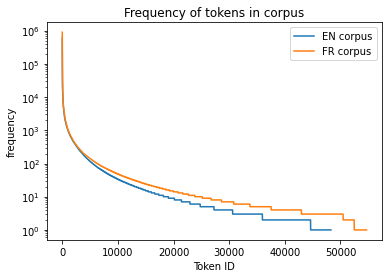

In [7]:
import matplotlib.pyplot as plt

for my_counter, corpus in zip(counters, corpus_name):
    plt.plot(range(len(my_counter.values())), sorted(my_counter.values(), reverse=True), label=f'{corpus} corpus')
    plt.yscale('log')
    plt.xlabel('Token ID')
    plt.ylabel('frequency')
    plt.title(f'Frequency of tokens in corpus')
plt.legend()
plt.savefig('token_frequency.png')
plt.show()

In [8]:
def compute_coverage2(ids, cutoff):
    total = ids.sum()
    return ids[:cutoff].sum()/total * 100.0

def multi_compute_coverage2(counter, cutoffs):
    ids = np.array(sorted(list(counter.values()),reverse=True))
    pcts = []
    for c in cutoffs:
        pcts += [compute_coverage2(ids, c)]
    return pcts

In [21]:
x = range(1, 60000, 10)
y1 = multi_compute_coverage2(counters[0], x)
y2 = multi_compute_coverage2(counters[1], x)

In [22]:
max2_en = 30000
max2_fr = 30000
pct2_en = multi_compute_coverage2(counters[0], cutoffs=[max2_en])
pct2_fr = multi_compute_coverage2(counters[1], cutoffs=[max2_fr])

print(f'EN Coverage with dictionary size {max2_en}: {pct2_en[0]}%')
print(f'FR Coverage with dictionary size {max2_fr}: {pct2_fr[0]}%')

EN Coverage with dictionary size 30000: 99.61032591883591%
FR Coverage with dictionary size 30000: 99.32295754083282%


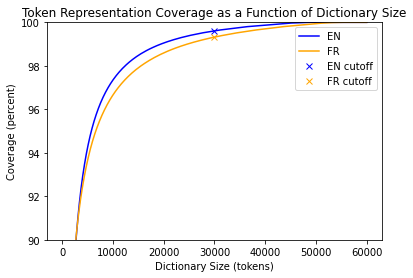

In [23]:
plt.plot(x, y1, label='EN', color='blue')
plt.plot(x, y2, label='FR', color='orange')
plt.plot(max2_en, pct2_en, 'x', label='EN cutoff', color='blue')
plt.plot(max2_fr, pct2_fr, 'x', label='FR cutoff', color='orange')
plt.xlabel('Dictionary Size (tokens)')
plt.ylim([90,100])
plt.ylabel('Coverage (percent)')
plt.title('Token Representation Coverage as a Function of Dictionary Size')
plt.legend()
plt.savefig('token_coverage.png')
plt.show()

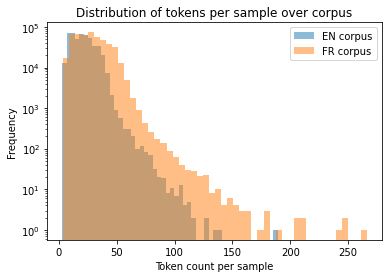

In [12]:
for line_lengths, corpus in zip(corpus_line_lengths, corpus_name):
    plt.hist(line_lengths, bins=50, alpha=0.5, label=f'{corpus} corpus')
plt.xlabel('Token count per sample')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title(f'Distribution of tokens per sample over corpus')
plt.legend()
plt.savefig('sample_length.png')
plt.show()

In [13]:
for line_lengths, corpus in zip(corpus_line_lengths, corpus_name):
    print(f'max number of tokens per {corpus} sentence: {max(line_lengths)}')

max number of tokens per EN sentence: 189
max number of tokens per FR sentence: 266


In [14]:
def compute_coverage(line_lengths, max_length):
    pct = np.sum(np.array(line_lengths) < max_length) / len(line_lengths) * 100.0
    return pct

def multi_compute_coverage(line_lengths, max_lengths):
    pcts = []
    for l in max_lengths:
        pcts += [compute_coverage(line_lengths, l)]
    return pcts

In [15]:
max_en = 80
max_fr = 120
pct_en = compute_coverage(corpus_line_lengths[0], max_length=max_en)
pct_fr = compute_coverage(corpus_line_lengths[1], max_length=max_fr)

In [16]:
x = range(1,128)
z1 = multi_compute_coverage(corpus_line_lengths[0], x)
z2 = multi_compute_coverage(corpus_line_lengths[1], x)

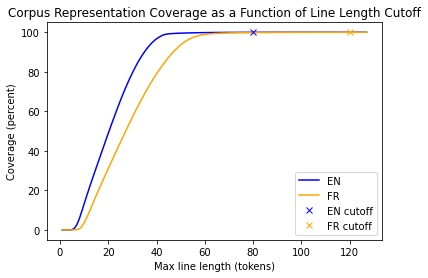

In [17]:
plt.plot(x, z1, label='EN', color='blue')
plt.plot(x, z2, label='FR', color='orange')
plt.plot(max_en, pct_en, 'x', label='EN cutoff', color='blue')
plt.plot(max_fr, pct_fr, 'x', label='FR cutoff', color='orange')
plt.xlabel('Max line length (tokens)')
plt.ylabel('Coverage (percent)')
# plt.ylim([99.9,100])
plt.title('Corpus Representation Coverage as a Function of Line Length Cutoff')
plt.legend()
plt.savefig('corpus_coverage.png')
plt.show()

In [18]:
max_lengths = [80, 120]
for line_lengths, corpus, max_length in zip(corpus_line_lengths, corpus_name, max_lengths):
    pct = compute_coverage(line_lengths, max_length)
    print(f'{corpus} Coverage with line length {max_length}: {pct}%')

EN Coverage with line length 80: 99.96865979381442%
FR Coverage with line length 120: 99.98061855670103%


In [19]:
for my_counter, corpus in zip(counters, corpus_name):
    print(f'Most common tokens in {corpus} corpus: {my_counter.most_common(10)}')
    print(f'Decoded: {[t_en.decode([t[0]]) for t in my_counter.most_common(10)]}')

Most common tokens in EN corpus: [(266, 599638), (0, 485000), (2, 485000), (282, 285881), (288, 281662), (299, 231661), (286, 195339), (263, 167964), (306, 157777), (310, 157378)]
Decoded: [' the', '', '', ' to', ' of', ' and', ' in', ' a', ' is', ' that']
Most common tokens in FR corpus: [(281, 899530), (0, 485000), (2, 485000), (272, 471563), (276, 471474), (11, 467177), (279, 459546), (289, 305467), (264, 229172), (302, 215907)]
Decoded: [' m', '', '', 'er', 'it', "'", ' b', 'al', 'in', 'le']
